# DLSP26U: Introduction to Deep Learning

**Name:** Hailemariam Mersha


**Instructions:**

In this notebook, you will be asked to write code and answer questions.  
Place all responses under the **Solution** headers.

---


This third assignment is aimed at coding the multiclass **soft perceptron** algorithm for multiclass classification and the **AdaLinE** algorithm for echo cancellation.

Below, we import the necessary libraries and set the random seed for reproducibility.

In [90]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio, display
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split

SEED = 0
np.random.seed(SEED)

## 1. Soft Perceptron (multi-class)

In the previous assignment, we introduced the soft perceptron algorithm for binary classification and in the one before that, we introduced the perceptron algorithm for binary and multi-class classification. In this assignment, we will introduce the soft perceptron algorithm for multi-class classification.

Recall that, given an input feature vector $\boldsymbol{f}(x) \in \mathbb{R}^d$, the multi-class perceptron algorithm **prediction** was defined as:
$$
\begin{align*}
\boldsymbol{s} &= \begin{pmatrix}
w_1^{\top} \boldsymbol{f}(x) \\
w_2^{\top} \boldsymbol{f}(x) \\
\vdots \\
w_K^{\top} \boldsymbol{f}(x)
\end{pmatrix}
\end{align*}
$$
where $w_k \in \mathbb{R}^d$ is the weight vector for class $k$. Then, to **decide** the class label, we would choose the class with the highest score:
$$
\begin{align*}
% \hat{y} &: \mathbb{R}^d \rightarrow \{1, 2, \ldots, K\} \\
\hat{y} &= \arg\max_{k} \boldsymbol{s}_k
\end{align*}
$$

---

This time, for the soft perceptron algorithm, we will introduce the **soft-argmax** function, often referred to as the softmax function. The softargmax function is defined as:
$$
\begin{align*}
\text{softargmax} &: \mathbb{R}^K \rightarrow \left( 0, 1 \right)^K \\
\text{softargmax}(\boldsymbol{s}) &= \frac{1}{\sum_{k=1}^{K}\exp(s_k)} \begin{pmatrix}
\exp(s_1) \\
\exp(s_2) \\
\vdots \\
\exp(s_K)
\end{pmatrix}
\end{align*}
$$

This function takes in input a $K$-dimensional vector of real numbers and outputs a $K$-dimensional vector of real numbers in the range $[0, 1]$ that **sum up to 1**. This enable us to interpret the output as a probability distribution over the $K$ classes. Moreover, the softargmax function can be parametrized by a coldness (or inverse temperature) parameter $\beta$:
$$
\begin{align*}
\text{softargmax} &: \mathbb{R}^K \rightarrow \left( 0, 1 \right)^K \\
\text{softargmax}_{}(\boldsymbol{s}) &= \frac{1}{\sum_{k=1}^{K}\exp(\beta s_k)} \begin{pmatrix}
\exp(\beta s_1) \\
\exp(\beta s_2) \\
\vdots \\
\exp(\beta s_K)
\end{pmatrix}
\end{align*}
$$

In this notebook we will always consider $\beta = 1$.

---

Having seen so, given a feature vector $\boldsymbol{f}(x) \in \mathbb{R}^d$, the multi-class soft perceptron algorithm **prediction** is defined as:
$$
\begin{align*}
\tilde{\boldsymbol{y}} &: \mathbb{R}^d \rightarrow \left( 0, 1 \right)^K \\
\tilde{\boldsymbol{y}} &= \text{softargmax} \left( \begin{pmatrix}
\boldsymbol{w}_1^{\top} \boldsymbol{f}(x) \\
\boldsymbol{w}_2^{\top} \boldsymbol{f}(x) \\
\vdots \\
\boldsymbol{w}_K^{\top} \boldsymbol{f}(x)
\end{pmatrix} \right)
\end{align*}
$$
where $\boldsymbol{w}_k \in \mathbb{R}^d$ is the weight vector for class $k$.

Then, to **decide** the class label, we would choose the class with the highest probability:
$$
\begin{align*}
\hat{y} &: \mathbb{R}^d \rightarrow \{1, 2, \ldots, K\} \\
\hat{y} &= \arg\max_{k} \tilde{y}_k
\end{align*}
$$

---

The last ingredient we need to introduce is the loss function. In the last assignment, we introduced the **binary cross-entropy loss**. In this assignment, we will introduce the **cross-entropy loss**, which is a generalization of the binary cross-entropy loss to the multi-class case.

First, we now that the total loss function is defined as the average of the per-sample loss function:
$$
\mathcal{L}(\boldsymbol{w}, \mathcal{D}) = \frac{1}{N} \sum_{n=1}^{N} L(\boldsymbol{w}, x_n, y_n)
$$
and this remains true.

Second, we need to define the per-sample loss function. In the binary case, we defined the per-sample loss function as:
$$
L(\boldsymbol{w}, x, y) = -y \log(\sigma[\boldsymbol{w}^{\top} \boldsymbol{f}(x)]) - (1 - y) \log(1 - \sigma[\boldsymbol{w}^{\top} \boldsymbol{f}(x)])
$$
where $\sigma$ is the sigmoid function. Notice that this is the average over the two possible classes $y = 0$ and $y = 1$.
Now, the classes we have to consider are $K$ and the per-sample loss function is defined as:
$$
\begin{align*}
L(\boldsymbol{w}, x, y) &=  - \log \left( \boldsymbol{y}^{\top} \tilde{\boldsymbol{y}} \right) \\
&= - \log \left( \tilde{\boldsymbol{y}}_{y} \right) \\
&= - \log \left( \text{softargmax} \left( \boldsymbol{w}^{\top} \boldsymbol{f}(x) \right)_{y} \right) \\
&= - \log \left( \frac{\exp( \boldsymbol{w}_{y}^{\top} \boldsymbol{f}(x))}{\sum_{k=1}^{K} \exp(\boldsymbol{w}_k^{\top} \boldsymbol{f}(x))} \right) \\
&= -  \boldsymbol{w}_y^{\top} \boldsymbol{f}(x) + \log \left( \sum_{k=1}^{K} \exp(\boldsymbol{w}_k^{\top} \boldsymbol{f}(x)) \right)
\end{align*}
$$
where $\boldsymbol{y} = \text{one-hot}_K(y)$ is the one-hot encoded vector of the class label, $y$ is the true class label and we use the $\boldsymbol{w}_y$ notation to denote the weight vector of the correct class label.

---

The last thing we need is the update rule. We know that in general, the update rule is defined as:
$$
\boldsymbol{W} \leftarrow \boldsymbol{W} - \nabla_{\boldsymbol{W}} \mathcal{L}(\boldsymbol{W}, \mathcal{D})
$$

Therefore we now explicitly compute the gradient of the loss function with respect to the weight matrix $W$:
$$
\begin{align*}
\nabla_{\boldsymbol{W}} \mathcal{L}(\boldsymbol{W}, \mathcal{D}) &= \frac{1}{N} \sum_{n=1}^{N} \nabla_{\boldsymbol{W}} L(\boldsymbol{W}, x_n, y_n) \\
\nabla_{\boldsymbol{W}} L(\boldsymbol{W}, x, y) &= \begin{pmatrix}
\nabla_{\boldsymbol{w}_1} L(\boldsymbol{w}_1, x, y) \\
\nabla_{\boldsymbol{w}_2} L(\boldsymbol{w}_2, x, y) \\
\vdots \\
\nabla_{\boldsymbol{w}_k} L(\boldsymbol{w}_k, x, y)
\end{pmatrix}  = \begin{pmatrix}
0 \\
\vdots \\
\nabla_{\boldsymbol{w}_y} \boldsymbol{w}_y^{\top} \boldsymbol{f}(x) \\
\vdots \\
0
\end{pmatrix} + \text{softargmax} \left( \boldsymbol{W}^{\top} \boldsymbol{f}(x) \right) \boldsymbol{f}^{\top}(x) \\
\nabla_{\boldsymbol{W}} L(\boldsymbol{W}, x, y) &= - \boldsymbol{y}\boldsymbol{f}^\top(x) + \text{softargmax} \left( \boldsymbol{W}^{\top} \boldsymbol{f}(x) \right) \boldsymbol{f}^\top(x)
\end{align*}
$$


We encourage you to try deriving this result yourself. Check out the [Matrix Cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) for help with differentiating vectors and matrices.

Therefore we have that the update rule is:
$$
\begin{align*}
\boldsymbol{W} &\leftarrow \boldsymbol{W} - \nabla_{\boldsymbol{W}} \mathcal{L}(\boldsymbol{W}, \mathcal{D}) \\
\boldsymbol{W} &\leftarrow \boldsymbol{W} + \left( \boldsymbol{y} - \tilde{\boldsymbol{y}} \right) \boldsymbol{f}(x)^{\top}
\end{align*}
$$

where $\tilde{\boldsymbol{y}} = \text{softargmax} \left( \boldsymbol{W}^{\top} \boldsymbol{f}(x) \right)$.

### Exercise 1.1 - Multi-class Soft Perceptron

The first exercise requires you to implement the multi-class soft perceptron algorithm using a Python class. Below is a template for the `MulticlassSoftPerceptron` class. You need to implement the methods `train`, `predict`, and `decide`:

- The `train` method should implement the perceptron learning algorithm. It should take as input both the training data and the number of epochs to train for.
- The `predict` method should take a data point `f` as input and return the vector of probabilities $\tilde{\boldsymbol{y}}$.
- The `decide` method should take a data point `f` as input and return the predicted class label $\hat{y}$.

**Useful functions:**
- `numpy.outer`

In [91]:
class MulticlassSoftPerceptron:

    @staticmethod
    def softargmax(s):
        raise NotImplementedError

    def __init__(self, n_features, n_classes):
        # Save the input parameters
        self.n_classes = n_classes
        self.n_features = n_features

        # Build the model parameters
        self.W = np.zeros((n_features, n_classes))
        self.b = np.zeros(n_classes)

    def train(self, F, y, epochs):
        raise NotImplementedError

    def predict(self, f):
        raise NotImplementedError

    def decide(self, f):
        raise NotImplementedError

**Solution**

In [92]:
class MulticlassSoftPerceptron:

    @staticmethod
    def softargmax(s):
        # I am trying to compute softmax in a numerically stable way
        z = s - np.max(s)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z)

    def __init__(self, n_features, n_classes):
        # Save parameters
        self.n_classes = n_classes
        self.n_features = n_features

        # Initialize model weights
        self.W = np.zeros((n_features, n_classes))
        self.b = np.zeros(n_classes)

    def train(self, F, y, epochs):
        for _ in range(epochs):
            for i in range(F.shape[0]):
                f = F[i]                              # Feature vector (d,)
                y_pred = self.predict(f)           # Softmax probabilities (K,)

                # One-hot encode the true label
                y_true = np.zeros(self.n_classes)
                y_true[y[i]] = 1

                # Update weights and bias
                self.W += np.outer(f, (y_true - y_pred))
                self.b += (y_true - y_pred)

    def predict(self, f):
        s = self.W.T @ f + self.b
        return self.softargmax(s)

    def decide(self, f):
        return np.argmax(self.predict(f))


### Exercise 1.2 - Cross Entropy

The second exercise requires you to implement the cross-entropy loss function. Below is a template for the `cross_entropy_loss` function.

In [93]:
def cross_entropy_loss(y_true, y_pred):
    raise NotImplementedError

**Solution:**

In [94]:
def cross_entropy_loss(y_true, y_pred):
    #eps = 1e-12
    #y_pred = np.clip(y_pred, eps, 1. - eps)   # avoid log(0)
    return -np.log(y_pred[y_true])


### Exercise 1.3 - Putting it all together

Now you can put in practice the `SoftPerceptron` class and the `cross_entropy_loss` function you implemented in the previous exercises.

1. Load the Iris dataset
2. Split the dataset into training and test sets
3. Train the `SoftPerceptron` model on the training set
4. Evaluate the loss on both the training and test sets

**Solution**

In [95]:
# 1) Load Iris
from sklearn.datasets import load_iris
data = load_iris()
X = data['data']          # (150, 4)
y = data['target']        # (150,)

# 2) Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# 3) Train model
model = MulticlassSoftPerceptron(n_features=X.shape[1], n_classes=3)
model.train(X_tr, y_tr, epochs=60)

loss_tr = 0.0
for i in range(len(y_tr)):
    p = model.predict(X_tr[i])                  # predicted probabilities (K,)
    loss_tr += cross_entropy_loss(y_tr[i], p)
loss_tr /= len(y_tr)

loss_te = 0.0
for i in range(len(y_te)):
    p = model.predict(X_te[i])
    loss_te += cross_entropy_loss(y_te[i], p)
loss_te /= len(y_te)

print(f"Train CE: {loss_tr} | Test CE: {loss_te}")


Train CE: 2.1977220049413244 | Test CE: 1.0910267194936335e-08


## 2. AdaLinE

AdaLinE (Adaptive Linear Neuron) is an adaptive filter, precursor of the single-layer neural networks. It attempts to model the relationship between two signals in real time in an iterative manner. It can be represented with the follwing block scheme

<p align="center">
  <img src="1 - Adaptive Filter.png" alt="Image description" width="60%" />
</p>
<p align="center"><i>Figure 1</i></p>

A digital input signal $\{x[n]\}$ is fed into the filter, that computes a corresponding output signal $\{\tilde{y}[n]\}$. The output signal is compared to a target signal $\{y[n]\}$ by subtraction, obtaining the error signal $\{e[n]\}$

$$
\begin{equation*}
    e[n] = y[n] - \tilde{y}[n]
\end{equation*}
$$

The error signal is fed into a procedure which adapts the the response. This process of adaptation is represented by the oblique arrow that pierces the adaptive filter block in the *Figure 1*.

In fact, the structure of the filter contains adjustable weights $\boldsymbol{w}$ whose values affect how the output is computed. Regarding its structure, AdaLinE can be categorized as a finite response (FIR) filter. The structure of this type of device is described throught a linear relationship with a limited respone in time. So the filter is nothing more than a linear combination between the weight vector $\boldsymbol{w}$ and the last $M$ samples of the input signal $\{x[n]\}$.

$$
\begin{equation*}
    \tilde{y}[n] = \boldsymbol{w}^\top\boldsymbol{f}[n] \in \mathbb{R}
\end{equation*}
$$

Where

$$
\begin{equation*}
    \boldsymbol{w} = \begin{bmatrix}w_0\\w_1\\ \vdots \\w_{M-1}\end{bmatrix} \in \mathbb{R}^M
\end{equation*}
$$
<br>
$$
\begin{equation*}
    \boldsymbol{f}[n] = \begin{bmatrix}x[n]\\x[n-1]\\ \vdots \\x[n-M+1]\end{bmatrix} \in \mathbb{R}^M
\end{equation*}
$$
<br>

A filter like AdaLinE can solve the general problem of system identification, depicted with the block scheme in the following figure.

<p align="center">
  <img src="2 - System Identification.png" alt="Image description" width="80%" />
</p>
<p align="center"><i>Figure 2</i></p>

In this diagram, the input signal $\{x[n]\}$ is fed into an unknown system that produces the desired signal $\{y[n]\}$, with the additional effect of another signal $\{s[n]\}$. From the error signal $\{e[n]\}$, the filter can model the unknown system through its weights.

In our context, the unknown system is represented by a room where the first speaker $\{x[n]\}$, emits a sound. The room introduces distortions to this signal, resulting in an room acoustics signal $\{a[n]\}$.

The signal $\{s[n]\}$ represents a second speaker, which is the one we want to hear. The target signal $\{y[n]\}$ is a mixture of all these effects, being the sum of the room's influence and the second speaker's sound.

The AdaLine output signal $\{\tilde{y}[n]\}$ estimates the target. When subtracted from the target signal, we obtain the error signal $\{e[n]\}$ which, in this scenario, represents a sound that should be very close to the one we want to hear.

## The Method of Steepest Descent
The method of steepest descent is an optimization procedure for minimizing the value of a cost function with respect to a set of weights $\boldsymbol{w}$. AdaLinE filter uses a particular form of this apporach, called least-mean-square (LMS) update algorithm.

$$
\begin{equation*}
    \boldsymbol{w} \gets \boldsymbol{w} + \eta \space (y[n] - \tilde{y}[n])\boldsymbol{f}[n]
\end{equation*}
$$

Here $\eta$ is the learning rate, so called because it determines the magnitude of the change that is taken by the algorithm in iteratively determining useful weights. This is a very delicate value that can easily influence the success of the method.

### Exercise 2.1 - Room system
In this first exercise, you are asked to set up the two systems that will later be used in the notebook. The first to be defined is the Room class, which implements the unknown system in Figure 2. This class must be such that:

- The first part of the room system parameters contains information about the delay introduced. To introduce a delay of `delay_samples` samples, it is necessary to insert a unit value after a series of zeros equal to the number of delay samples, for each signal repetition.

- The second part of the room system parameters contains information about the introduced reverberation. Since reverberation is like the signal repeating itself in a weaker and weaker manner, to implement it, it is necessary to place a decreasing intensity below the unit value after the noise samples.

- The last part of the parameters must contain padding zeros.

This system, like the AdaLinE filter that follows it, works with a type of signal called a tapped delay line $F$. A tapped delay line essentially samples the input signal by selecting sliding windows of its values, with each window shifted by one position for each successive sample. These elements are nothing more than the $\boldsymbol{f}[n]$ samples.

<br>
$$
\begin{equation*}
    F = \begin{bmatrix}\boldsymbol{f}^\top[0] \\ \boldsymbol{f}^\top[1] \\ \vdots \\ \boldsymbol{f}^\top[N-1] \end{bmatrix} \in \mathbb{R}^{N \times M}
\end{equation*}
$$
<br>

With this in mind, It is possible to implement the `room_effect` method,In which the effect, and therefore the output, of the system is applied just like an adaptive filter.

In [96]:
class Room:
    def __init__(self,delay_samples,reverb_samples):
        # Room parameters
        self.pad_right = delay_samples - 1
        total_params = delay_samples + reverb_samples + self.pad_right
        if total_params % 2 == 0:
            total_params += 1

        self.valid_params = delay_samples + reverb_samples
        self.room_params = np.zeros((total_params,1))

        # Delay
        ... # TODO

        # Reverb
        ... # TODO

        # Right padding
        ... # TODO

    def room_effect(self, x):
        N = len(x)
        room_acoustic = np.zeros(N)

        for n in tqdm(range(N), desc="Applying room effect"):
            # Extract window: f[n] = [x[n], x[n-1], ..., x[n-M+1]]^T
            fn = np.zeros((len(self.room_params),1))

            for i in range(len(self.room_params)):
                idx = n - i
                if idx >= 0:
                    fn[i] = x[idx]

            # Training step
            room_acoustic[n] = (...).item() # TODO

        return room_acoustic.reshape((-1,1))

    def room_parameters(self):
        return self.room_params

**Solution**

In [ ]:
class Room:
    def __init__(self, delay_samples, reverb_samples):
        # Room parameters
        self.pad_right = delay_samples - 1
        total_params = delay_samples + reverb_samples + self.pad_right
        if total_params % 2 == 0:
            total_params += 1

        self.valid_params = delay_samples + reverb_samples
        self.room_params = np.zeros((total_params, 1))

        # ----- Delay -----
        self.room_params[delay_samples - 1, 0] = 1.0

        # ----- Reverb -----
        decay = 0.6  # fixed internal decay 
        for i in range(1, reverb_samples + 1):
            self.room_params[delay_samples - 1 + i, 0] = decay ** i

        # ----- Right padding -----
        if self.valid_params < total_params:
            self.room_params[self.valid_params:, 0] = 0.0

    def room_effect(self, x):
        N = len(x)
        room_acoustic = np.zeros(N)
        M = len(self.room_params)

        for n in tqdm(range(N), desc="Applying room effect"):
            fn = np.zeros((M, 1))
            for i in range(M):
                idx = n - i
                if idx >= 0:
                    fn[i, 0] = x[idx]

            # Output: y[n] = h^T f[n]
            room_acoustic[n] = float(self.room_params[:, 0] @ fn[:, 0])

        return room_acoustic.reshape((-1, 1))

    def room_parameters(self):
        return self.room_params


### Exercise 2.2 - AdaLinE filter
Once we have defined the signals, we need to define the tool with which to manipulate them, i.e. the AdaLinE filter.

Based on this, in this exercise, you are tasked with implementing the `ADALINE` class that realizes this entity. In particular, based on the concepts of FIR filters, the class must include:

- the `predict` method that returns the estimated target signal $\{\tilde{y}[n]\}$, given the input signal.
- the `train_step` method implements an iteration of the LMS method (remember to save the error $e[n]  = y[n] - \tilde{y}[n]$ in this case) and returns the estimation of the filter at that step.
- the `train` for each sample of the input signal, apply the LMS update (hint: it works exactly like the room effect...)
- the `apply` method, which, given the input signal, returns the signal
estimated by the filter (hint: again, remember how the room effect works).

In [98]:
class ADALINE:
    def __init__(self, M, eta):
        self.M = M
        self.eta = eta
        self.w = np.zeros((M,1))
        self.errors = []

    def predict(self, fn):
        return NotImplementedError

    def train_step(self, fn, yn):
        return NotImplementedError

    def train(self, x, y):
        raise NotImplementedError

    def apply(self,x):
        return NotImplementedError

**Solution**

In [99]:
class ADALINE:
    def __init__(self, M, eta):
        self.M = M
        self.eta = eta
        self.w = np.zeros((M,1))
        self.errors = []

    def predict(self, fn):
        return float(self.w[:, 0] @ fn[:, 0])

    def train_step(self, fn, yn):
        yhat = self.predict(fn)
        e = yn - yhat
        self.w += self.eta * e * fn   # w ← w + η e fn
        self.errors.append(e)
        return yhat

    def train(self, x, y):
        N = len(x)
        for n in range(N):
            fn = np.zeros((self.M, 1))
            for i in range(self.M):
                idx = n - i
                if idx >= 0:
                    fn[i, 0] = x[idx]
            self.train_step(fn, y[n])

    def apply(self, x):
        N = len(x)
        y_pred = np.zeros((N, 1))
        for n in range(N):
            fn = np.zeros((self.M, 1))
            for i in range(self.M):
                idx = n - i
                if idx >= 0:
                    fn[i, 0] = x[idx]
            y_pred[n, 0] = self.predict(fn)
        return y_pred


### Exercise 2.3 - System setup
This second exercise addresses an application scenario. In this case, it is essential to set up the signals required for the experiment, as illustrated in *Figure 2*:

- The input signal $\{x[n]\}$ represents the first speaker and is modeled as a square wave signal with a fundamental frequency of $1000~\textrm{Hz}$.

- The sound signal $\{s[n]\}$, represents the second speaker and is modeled as a sinusoidal signal with a frequency of $554~\textrm{Hz}$. The amplitude of this signal is slightly lower than that of $\{x[n]\}$

- The audio signal $\{a[n]\}$ is the output of the room system, which includes both the delay of \($4$ samples\) and reverb effects ($6$ samples\) applied to the first speaker's signal $\{x[n]\}$. This signal must be of the same length of the sound signal

- The target signal $\{y[n]\}$ that sums the audio signal and the second speaker signal

In [100]:
fs = 8000  
duration = 0.5  
t = np.linspace(0, duration, int(fs * duration)) 

**Solution**

In [101]:
fx = 1000
x = signal.square(2 * np.pi * fx * t) # amplitude in [-1,1]

fs2 = 554
s = 0.9 * np.sin(2 * np.pi * fs2 * t).astype(np.float32)

room = Room(delay_samples=4, reverb_samples=6)
a = room.room_effect(x).reshape(-1)

y = (a + s).astype(np.float32)


Applying room effect: 100%|██████████| 4000/4000 [00:00<00:00, 394442.47it/s]


### Exercise 2.4 - Learning delay and reverb
We now need to update the filter weights so that the AdaLinE filter can approximate the response of the unknown room system:

- Determine how many filter weights $\boldsymbol{w}$ are needed to effectively model the system
- Choose a suitable learning rate $\eta$ for the weight update algorithm, ensuring the filter converges without overshooting
- Initialize the filter and train it
- Plot the error curve using the stored error values

In [102]:
def plot_error_curve(errors):
    # Figure
    fig, ax = plt.subplots(figsize=(12, 5))

    # Error plot data
    errors_squared = np.array(errors) ** 2
    n = np.arange(len(errors))

    # Plot moving average for a smoother view
    window = min(100, len(errors) // 10)
    mse_smooth = np.convolve(errors_squared, np.ones(window)/window, mode="valid")
    ax.plot(n[window-1:], mse_smooth, "darkblue", linewidth=1)

    ax.set_xlabel("Iteration", fontsize=11)
    ax.set_ylabel("Squared Error", fontsize=11)
    ax.set_title("Average error during train", fontsize=12, fontweight="bold")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

**Solution**

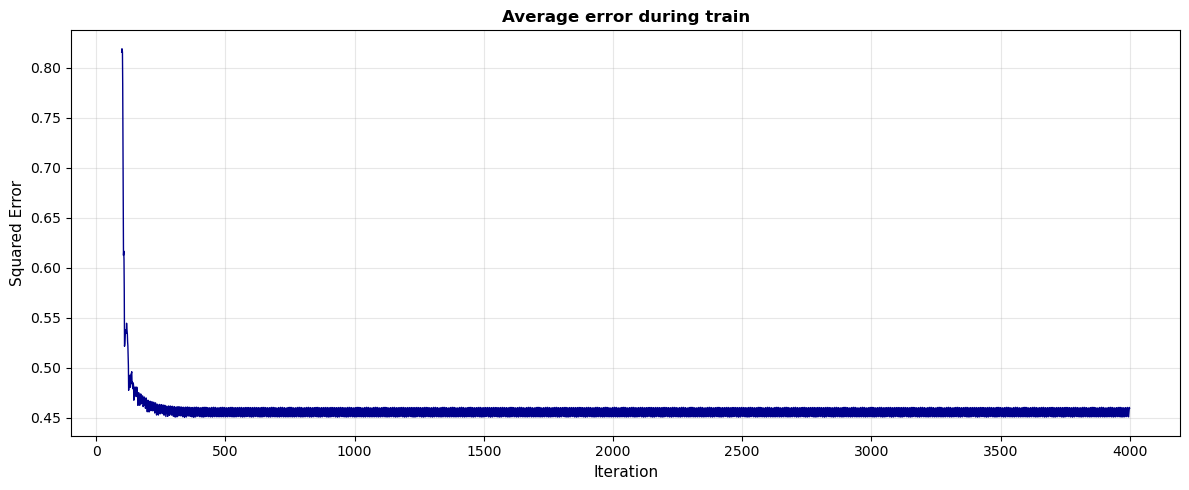

In [103]:
M = len(room.room_parameters())
eta = 0.01

adaline = ADALINE(M=M, eta=eta)
adaline.train(x, y)

plot_error_curve(adaline.errors)


### Exercise 2.5 - Evaluation
Visualize the weights and signals to check the filter behavior. If everything is working correctly, you should be able to see AdeLinE weights that resemble the parameters of the room system and the error signal $\{e[n]\}$ closely resembles the second speaker signal $\{s[n]\}$.

In [104]:
def plot_weights(room_parameters, w):
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))

    titles = ["Room (room_parameters)", "ADALINE (w)"]
    colors = ["orange", "red"]
    ws = [room_parameters, w]

    for ax, w, title, color in zip(axes, ws, titles, colors):
        n = np.arange(len(w))
        markers, stems, base = ax.stem(n, w, basefmt=" ")
        plt.setp(stems, linewidth=1.8, color=color)
        plt.setp(markers, markersize=6, color=color, marker="o")

        ax.set_title(title, fontsize=12, fontweight="bold")
        ax.set_xlabel("Index")
        ax.set_ylabel("Amplitude")
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color="k", linewidth=0.8)

    plt.tight_layout()
    plt.show()

In [105]:
def plot_signals(x, y, y_pred, s, a, e, zoom=True):
    # Figure regulation (to show significative sections)
    N = len(x)
    n = np.arange(N)

    if zoom:
        zoom_samples=(1000, 1500)
        n_start, n_end = zoom_samples
        n_start = max(0, n_start)
        n_end = min(N, n_end)
    else:
        n_start, n_end = 0, N

    n = np.arange(N)[n_start:n_end]

    # Figure
    fig, ax = plt.subplots(5, 1, figsize=(14, 12))

    # Input signal x[n]
    ax[0].plot(n, x[n_start:n_end], "blue", linewidth=1, alpha=0.7)
    ax[0].set_ylabel("x[n]", fontsize=11)
    ax[0].set_title(f"Input signal - Speaker 1", fontsize=12, fontweight="bold")
    ax[0].set_xlabel("n", fontsize=11)
    ax[0].grid(True, alpha=0.3)

    # Sound signal s[n]
    ax[1].plot(n, s[n_start:n_end], "orange", linewidth=1, alpha=0.7)
    ax[1].set_ylabel("s[n]", fontsize=11)
    ax[1].set_title("Sound Signal - Speaker 2", fontsize=12, fontweight="bold")
    ax[1].set_xlabel("n", fontsize=11)
    ax[1].grid(True, alpha=0.3)

    # Room output a[n]
    ax[2].plot(n, a[n_start:n_end], "purple", linewidth=1, alpha=0.7)
    ax[2].set_ylabel("a[n]", fontsize=11)
    ax[2].set_title("Audio Signal - Room Output", fontsize=12, fontweight="bold")
    ax[2].set_xlabel("n", fontsize=11)
    ax[2].grid(True, alpha=0.3)

    # Target signal y[n] vs Filter output \tilde{y}[n]
    ax[3].plot(n, y[n_start:n_end], "green", linewidth=1, alpha=0.7, label="y[n] = a[n] + s[n]")
    ax[3].plot(n, y_pred[n_start:n_end], "r--", linewidth=1, alpha=0.8, label=r"$\tilde{y}[n]$ (filter output)")
    ax[3].set_ylabel(r"y[n]/$\tilde{y}[n]$", fontsize=11)
    ax[3].set_xlabel("n", fontsize=11)
    ax[3].set_title("Target Signal vs Filter output", fontsize=12, fontweight="bold")
    ax[3].legend(loc="upper right")
    ax[3].grid(True, alpha=0.3)

    # Error signal e[n] - What we want to listen
    ax[4].plot(n, e[n_start:n_end], "darkgreen", linewidth=0.8, alpha=0.7)
    ax[4].set_ylabel("e[n]", fontsize=11)
    ax[4].set_xlabel("n", fontsize=11)
    ax[4].set_title("Error Signal (ideally ≈ {s[n]})", fontsize=12, fontweight="bold")
    ax[4].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Another clear way to verify if everything has worked is by listening to the signals. Use the save_audio function along with `IPython package` (`Audio` and `display`) to listen to the signal and check if $\{e[n]\}$ resembles the sound from the second speaker $\{s[n]\}$.

In [106]:
def save_audio(filename, signal, fs):
    signal_normalized = np.int16(signal / np.max(np.abs(signal)) * 32767 * 0.9)
    wavfile.write(filename, fs, signal_normalized)

**Solution**

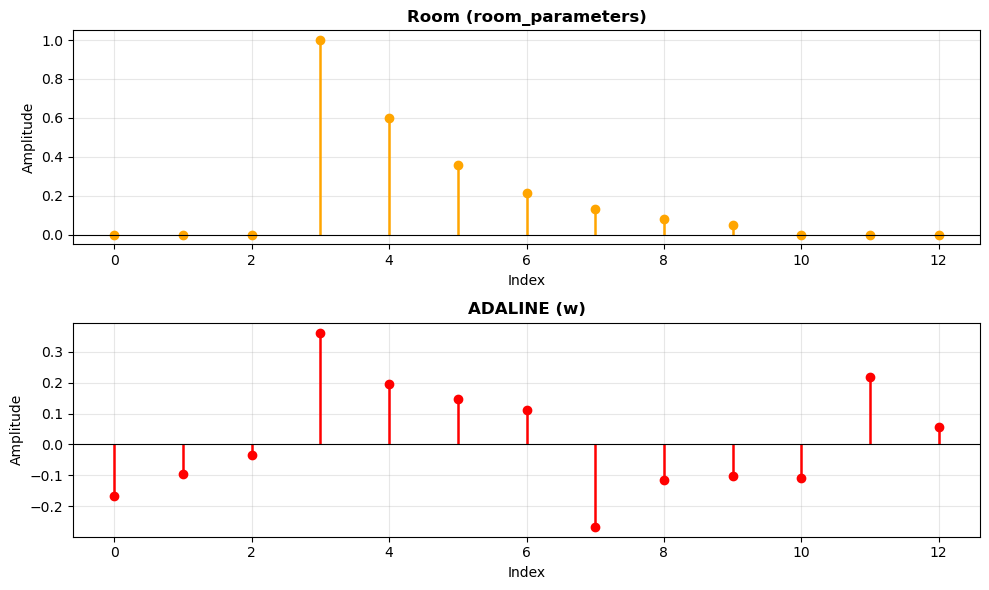

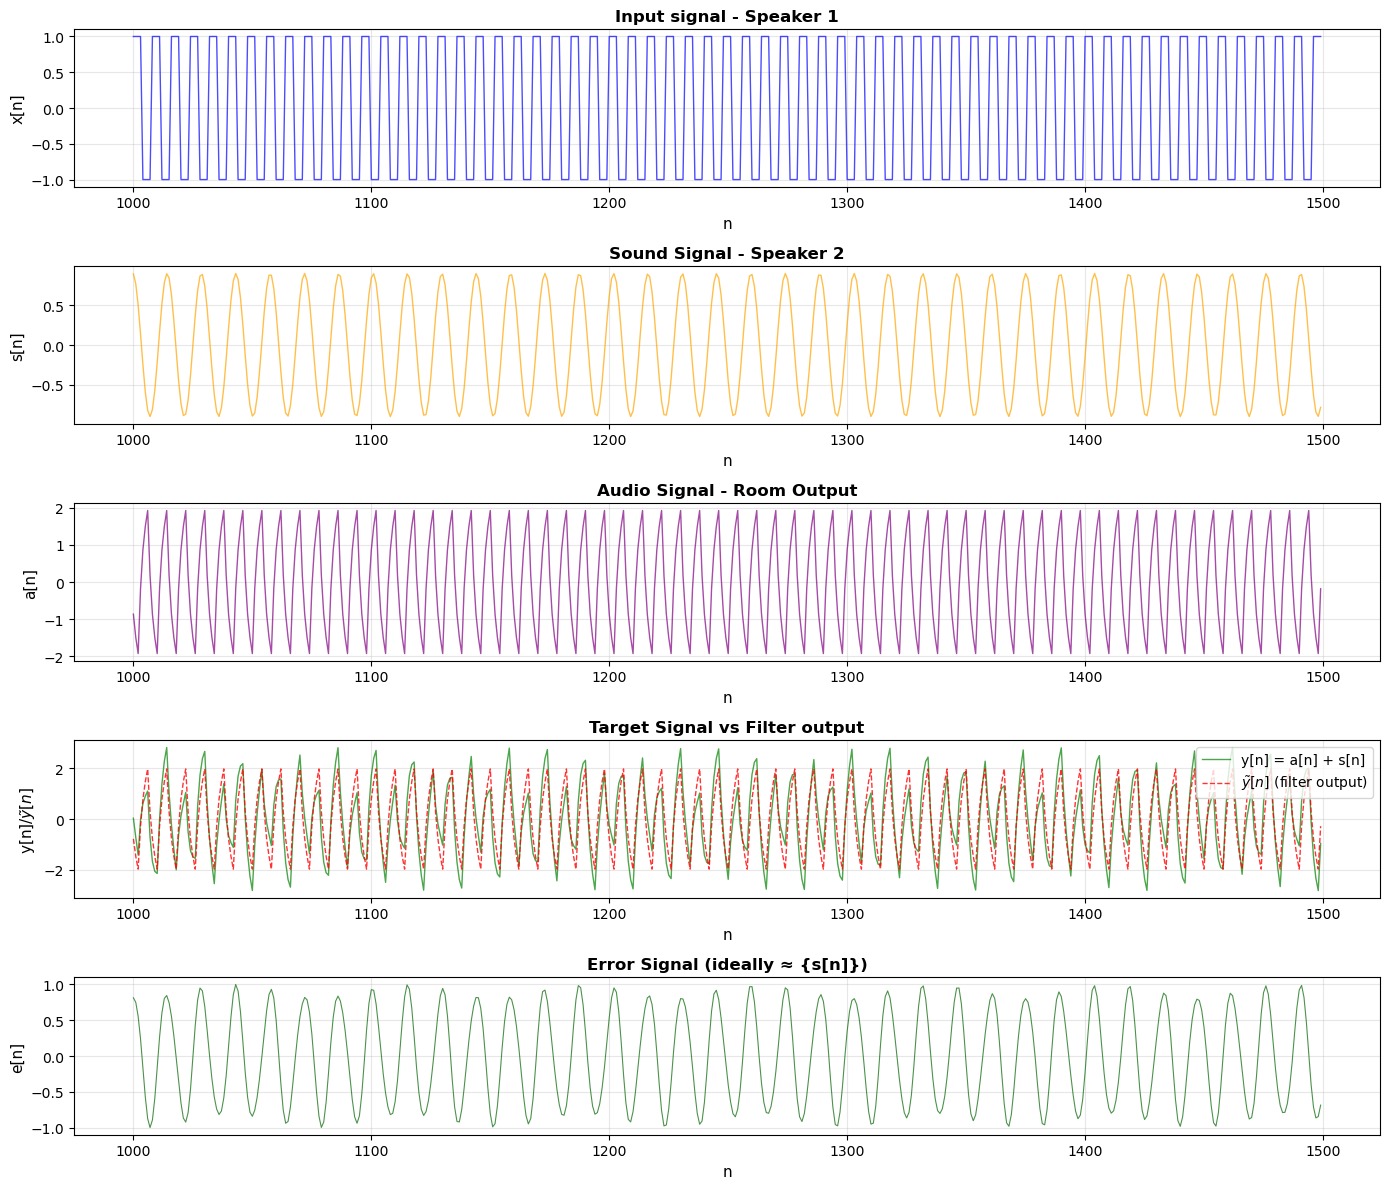

In [107]:

plot_weights(room.room_parameters().flatten(), adaline.w.flatten())

y_pred = adaline.apply(x).reshape(-1)
e = y - y_pred  

plot_signals(x=x, y=y, y_pred=y_pred, s=s, a=a, e=e, zoom=True)



## 3. Listening is believing

This final exercise focuses on using AdaLinE with WAV signals, providing a practical way to understand how these tools can be applied in real-world scenarios.


### Exercise 3.1 - A personalized example

First of all you need to load the signal $\{x[n]\}$ (*one.wav*) and $\{s[n]\}$ (*two.wav*). Note that the WAV files must be present in the same directory as this notebook.

In [108]:
def load_sound(wav_file):
    fs, x = wavfile.read(wav_file)

    # Conversion and normalization
    if x.dtype == np.int16:
        x = x.astype(np.float32) / 32768.0
    elif x.dtype == np.int32:
        x = x.astype(np.float32) / 2147483648.0
    else:
        x = x.astype(np.float32)

    # If stereo, just one channel
    if len(x.shape) > 1:
        x = x[:, 0]

    return x,fs

**Solution**

In [109]:
# Load WAVs
x_raw, fs_x = load_sound("one.wav")
s_raw, fs_s = load_sound("two.wav")


/var/folders/bg/rr1v108n1851vd88zm17s0280000gn/T/ipykernel_14479/2959216787.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x = wavfile.read(wav_file)


The first $8000$ samples of the two signals are zero and must be eliminated. Furthermore, the two signals must have the same number of samples. The room's acoustic signal $\{a[n]\}$ must be set with a delay of $20$ samples and a reverberation of $6$ samples. The signal $\{y[n]\}$ is obtained as in the previous case.

**Solution**

In [110]:
assert fs_x == fs_s, "Sample rates must match"
fs = fs_x

# Drop first 8000 samples
drop = 8000
xw = x_raw[drop:]
sw = s_raw[drop:]

# Match lengths
N = min(len(xw), len(sw))
xw = xw[:N].astype(np.float32)
sw = sw[:N].astype(np.float32)

room_wav = Room(delay_samples=20, reverb_samples=6)
aw = room_wav.room_effect(xw).reshape(-1).astype(np.float32)
aw = aw[:N]

# Target
yw = (aw + sw).astype(np.float32)


Applying room effect: 100%|██████████| 37506/37506 [00:00<00:00, 139760.57it/s]


### 3.2 AdaLinE pipeline

At this point, you can apply the pipeline from the previous exercise: train AdaLinE, plot weights and signals, and listen to the resulting signals. To better visualize the signals, in this case remember to set the plot function parameter `zoom=False`.

**Solution**

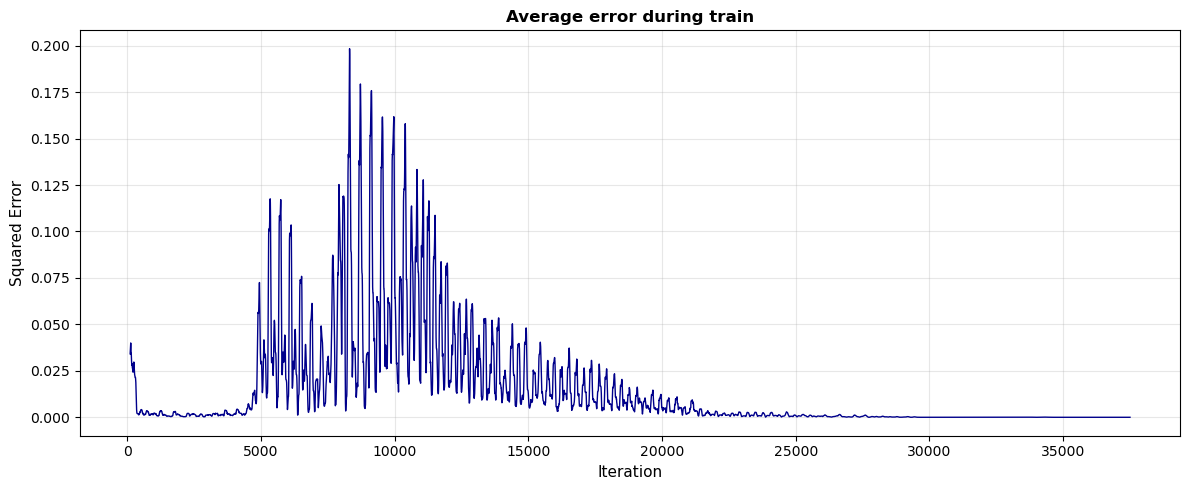

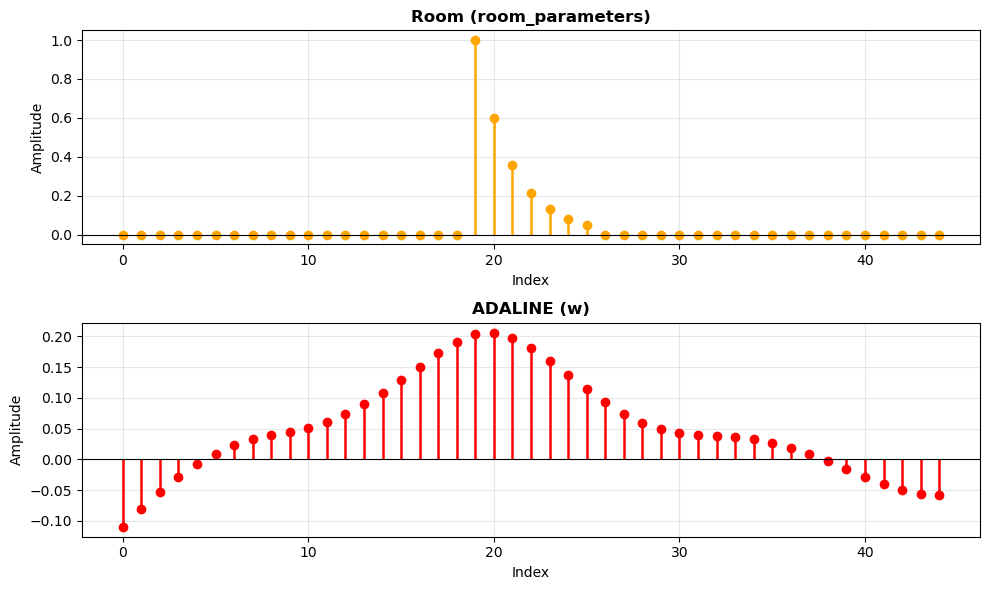

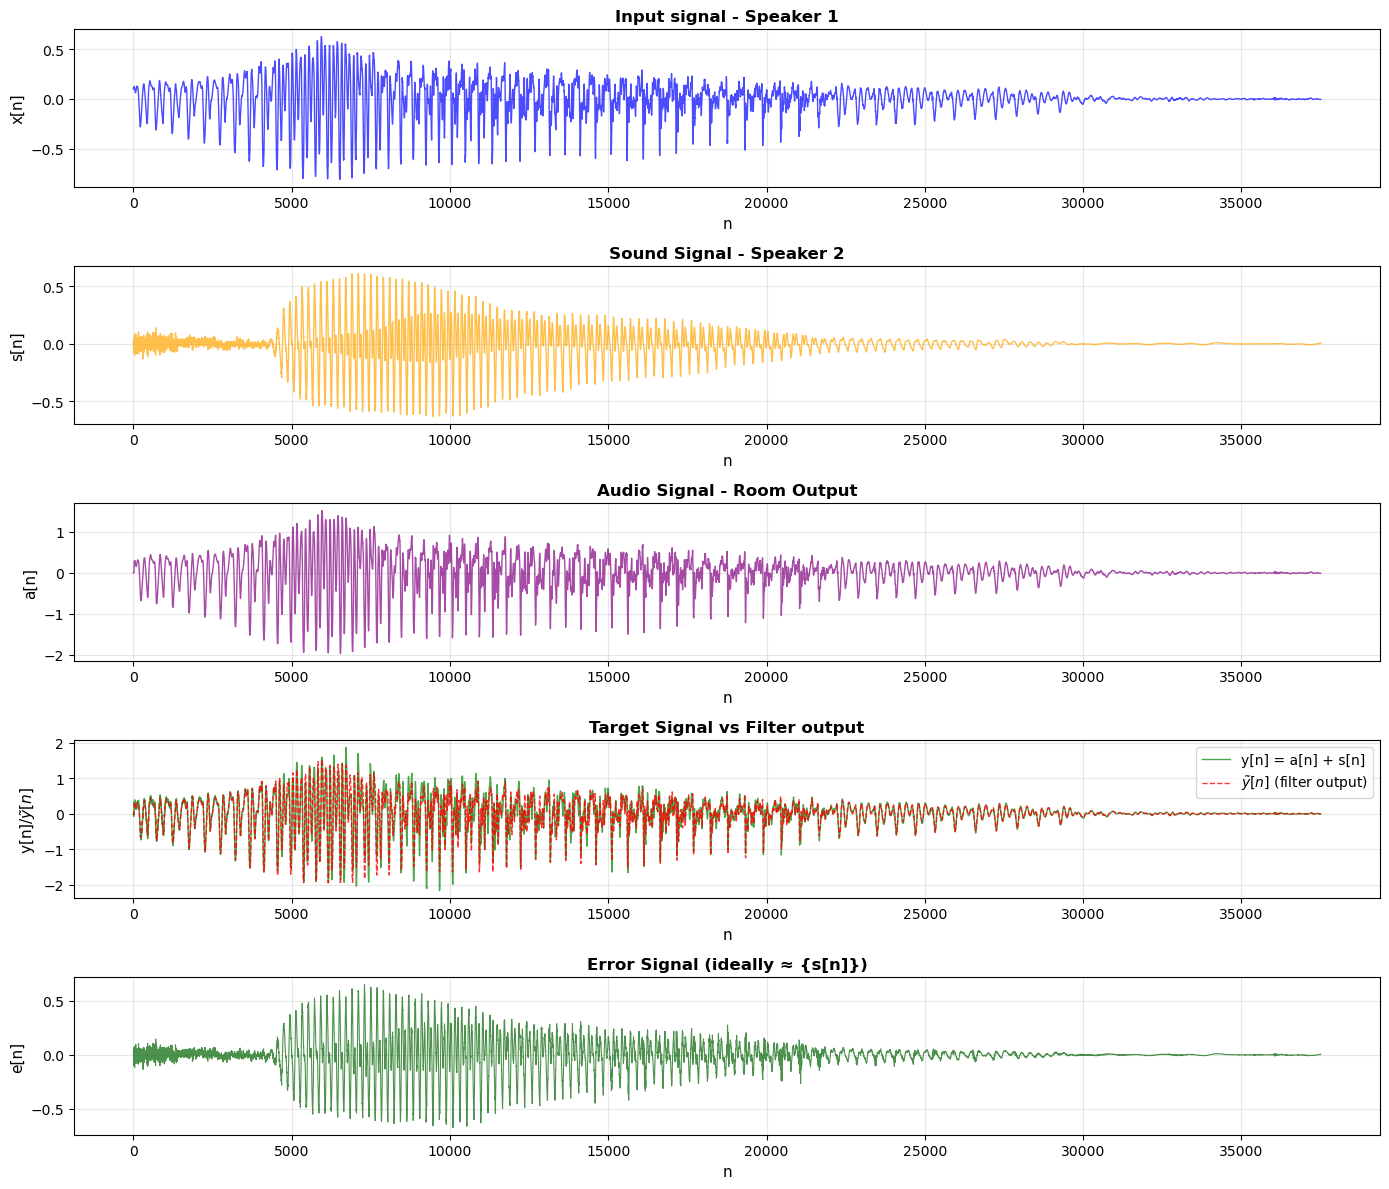

In [111]:
Mw = len(room_wav.room_parameters())
eta_w = 0.01

adaline_w = ADALINE(M=Mw, eta=eta_w)
adaline_w.train(xw, yw)

yhat_w = adaline_w.apply(xw).reshape(-1)
ew = yw - yhat_w
plot_error_curve(adaline_w.errors)
plot_weights(room_wav.room_parameters().flatten(), adaline_w.w.flatten())
plot_signals(x=xw, y=yw, y_pred=yhat_w, s=sw, a=aw, e=ew, zoom=False)

# (Optional listening/saving)
save_audio("mix_y.wav", yw, fs)
save_audio("adaline_out.wav", yhat_w, fs)
save_audio("error_close_to_s.wav", ew, fs)
display(Audio(ew, rate=fs))
display(Audio(yw, rate=fs))
display(Audio(xw, rate=fs))
display(Audio(aw, rate=fs))